# Statistics

# import functions

In [160]:
#python functions
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from timeinfo import day_night
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter1d
import os, glob, datetime, gsw, cmocean, math
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skbio.stats.ordination import cca
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import maskoceans
from scipy.interpolate import griddata
import seaborn as sns
from pandas.plotting import scatter_matrix

In [ ]:
# R functions install one time enough
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# utils.install_packages("vegan") done

In [ ]:
# Import R packages
vegan = rpackages.importr("vegan")
# vegan.__dict__['_rpy2r'] to see possible functions

# datafram conversion python to R
# Allow conversion
import rpy2.robjects as ro


# import data

In [2]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
plt_path = os.path.expanduser('~/Git/OCEANpy/plots')
loki_df = export_sql('loki', 'all', 'awi_server')
mn_df = export_sql('mn', 'all', 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_stb = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()]


# basic value

In [82]:
wm_dict = {'PS107_010-5': (70, 95), 'PS107_012-4': (70, 155), 'PS107_014-5': (50, 215), 'PS107_016-4': (100, 270)}
loki_vol = {'PS107_016-4': (500, 53.4303), 'PS107_010-5': (500, 51.22524), 'PS107_012-4': (500, 77.94039), 'PS107_014-5': (500, 75.4809)}
loki_stations = ('PS107_016-4', 'PS107_010-5', 'PS107_012-4', 'PS107_014-5')
mn_stations = ('PS107_016-5', 'PS107_010-6', 'PS107_012-5', 'PS107_014-6')
ctd_stations = ('PS107_16-3', 'PS107_10-4', 'PS107_12-3', 'PS107_14-1')
loki_df_sel = loki_df.loc[loki_df['station'].str.contains('|'.join(loki_stations))]
mn_df_sel = mn_df.loc[mn_df['station'].str.contains('|'.join(mn_stations))]

# station map

In [5]:
topo_array = bathy_data (70, 90, -20, 20) # -30, 30, 75, 85
ctd_df_sel = ctd_df.loc[ctd_df['Event'].str.contains('|'.join(ctd_stations))]

In [6]:
lat = list(pd.to_numeric(ctd_df_sel['Latitude']).drop_duplicates().values)
lon = list(pd.to_numeric(ctd_df_sel['Longitude']).drop_duplicates().values)

In [19]:
# maps

fig = plt.figure(figsize =(8, 6))


m = Basemap(projection='eqdc', lat_0 = 78, lon_0 = 0,lat_1=70, resolution = 'h',
        llcrnrlon = -15, llcrnrlat = 76, urcrnrlon = 13, urcrnrlat = 80.5)
m.drawcoastlines(linewidth=0.1)
m.drawmapboundary()
m.fillcontinents(color='lightgrey')
#m.shadedrelief()
#m.drawcountries()
#m.arcgisimage(service='Ocean_Basemap', xpixels = 5000)

m.drawparallels(np.arange(60, 86, 5), labels=[1,0,0,0], fontsize=18) # line for latitude 
m.drawmeridians(np.arange(-30, 30, 10), labels=[0,0,0,1], fontsize=18) # line for longitude


# add text
f_x, f_y = m(-8, 80)
plt.text(f_x, f_y, 'Fram Strait', size=24, color='dodgerblue')

g_x, g_y = m(-18.5, 79.4)
plt.text(g_x, g_y, 'Greenland', size=19, color='black')

s_x, s_y = m(6, 79.5)
plt.text(s_x, s_y, 'Svalbard', size=19, color='black')



b_lats = [ 78.6, 79.1, 79.1, 78.6 ]
b_lons = [ 1, 1, 3.5, 3.5 ]
x, y = m( b_lons, b_lats )
xy = zip(x,y)
poly = Polygon( list(xy), facecolor='none', ec='red', linewidth=1.5)
plt.gca().add_patch(poly)



## subplot
ax2 = fig.add_axes([0.16, 0.22, 0.3, 0.3])
m = Basemap(projection='merc', lat_0 = 79, lon_0 = 2.5, resolution = 'h',
        llcrnrlon = 2, llcrnrlat = 78.87, urcrnrlon = 3.1, urcrnrlat = 79.05)
m.drawcoastlines(linewidth=0.4)
m.drawmapboundary()
m.fillcontinents(color='lightgrey')

m.drawparallels(np.arange(60, 86, 0.5), labels=[0,1,0,0], fontsize=15, linewidth=0.2) # line for latitude 
m.drawmeridians(np.arange(-30, 30, 0.5), labels=[0,0,1,0], fontsize=15, linewidth=0.2) # line for longitude

# add station point
lon_x, lat_y = m(lon, lat)
ax2.scatter(lon_x, lat_y, color='orangered')


x_16, y_16 = m(2.284 , 79.0045)
ax2.text(x_16, y_16, '16', fontsize=15)
x_10, y_10 = m(2.496 , 78.9768)
ax2.text(x_10, y_10, '10', fontsize=15)
x_12, y_12 = m(2.71 , 78.9448)
ax2.text(x_12, y_12, '12', fontsize=15)
x_14, y_14 = m(2.86 , 78.92699999999999)
ax2.text(x_14, y_14, '14', fontsize=15)

m.drawmapscale(2.3 , 78.89, 2.3 , 78.98, 50, barstyle='fancy')

plt.savefig(os.path.join(plt_path,'station_map.pdf'), dpi=300)
#plt.show()
plt.close()

In [18]:
# vertical
depth = list(pd.to_numeric(ctd_df_sel['Depth water [m]']).values)
lat = list(pd.to_numeric(ctd_df_sel['Latitude']).values)
lon = list(pd.to_numeric(ctd_df_sel['Longitude']).values)

# create array for contour
temp = list(pd.to_numeric(ctd_df_sel['Temp [°C]']).values)
temp_array = np.array((lat, lon, temp, depth)).transpose()

sal_levels = (32, 34, 34.4, 34.6, 34.8, 35)
sal = list(pd.to_numeric(ctd_df_sel['Sal']).values)
sal_array = np.array((lat, lon, sal, depth)).transpose() # create array

# plotting
fig, ax = plt.subplots(figsize=(18,7))
temp_cntr = ax.tricontourf(temp_array[:,1], temp_array[:,3], temp_array[:,2], 50, cmap='jet') # add contour of temp with filled
sal_cntr = ax.tricontour(sal_array[:,1], sal_array[:,3], sal_array[:,2], levels=sal_levels, colors='black', linewidths=1, linestyles='--') # add contour of temp with filled
c_labels = ax.clabel(sal_cntr, inline=50, fontsize=17, levels=sal_levels, fmt='%1.1f')


cbar = fig.colorbar(temp_cntr, pad=0.01, ticks = range( math.floor(np.nanmin(temp_array[:,2])), math.ceil(np.nanmax(temp_array[:,2])),
                                        math.ceil(abs(math.floor(np.nanmin(temp_array[:,2]))-math.ceil(np.nanmax(temp_array[:,2])))/10)) )
cbar.ax.set_ylabel('Temperature [$^\circ$C]', rotation=90, labelpad=2, size=18)  # Fluorescence [mg m$^{-3}$] / Temp [dC] / Salinity [PSU] / Press [dbar]
cbar.ax.tick_params(axis='y', labelsize=15)

for l in c_labels:
    l.set_rotation(0)


ax.scatter(lon, depth, color='black', s=0.09) # add scatter for data point

# adjust
plt.ylim(-50, 550)
plt.xlim(2.27, 2.86)
plt.gca().invert_yaxis()


# label control
plt.ylabel('Depth [m]', size=18)
plt.xlabel('Longitude', size=18)
plt.tick_params(axis='both', labelsize=15)

# add text
plt.text(2.277, 535, '16', size=18)
plt.text(2.488, 535, '10', size=18)
plt.text(2.695, 535, '12', size=18)
plt.text(2.845, 535, '14', size=18)

plt.gca().add_patch(Rectangle((2.472, -40), 0.05, 50, facecolor='lightskyblue', ec='white'))
plt.text(2.489, -5, 'ICE', size=18)

fig.tight_layout()

plt.savefig(os.path.join(plt_path,'vertical_map.pdf'), dpi=300)
#plt.show()
plt.close()

# Hydrography data

In [17]:

fig_anot = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

fig = plt.figure(constrained_layout=False, figsize =(19, 9))
gs = fig.add_gridspec(1, 4)

n = 0
for i in loki_stations:
    up, down = wm_dict[i]
    cruise, station = i.split('_')[0], int(i.split('_')[1].split('-')[0])
    loki_station_df = loki_df_sel.loc[loki_df_sel['station'] == i]
    ctd_station_df = ctd_df.loc[ctd_df['Event'].str.contains(str(cruise+'_'+str(station)))]


    ax = fig.add_subplot(gs[0,n])
    ax.plot(tuple(pd.to_numeric(ctd_station_df['Sal'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='black', linewidth= 1)
    ax.set_xlabel('Salinity [PSU]', color = 'black', fontsize=15)
    ax.set_ylim(0,500)
    ax.set_xlim(29,36)
    ax.tick_params(axis='both', labelsize=18)

    sec_axs = ax.twiny()
    sec_axs.plot(tuple(pd.to_numeric(ctd_station_df['Temp [°C]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='red', linewidth= 1)
    sec_axs.set_xlim(-2,6)
    sec_axs.set_xlabel('Temperature [$^\circ$C]', color = 'red', fontsize=15)
    sec_axs.tick_params(axis='x', labelsize=18)

    
    thr_axs = ax.twiny()
    thr_axs.spines['bottom'].set_position(('outward', 50))  # make new outmost axis                  
    thr_axs.xaxis.set_ticks_position('bottom')
    thr_axs.xaxis.set_label_position('bottom')
    thr_axs.plot(tuple(pd.to_numeric(ctd_station_df['Fluorometer [arbitrary units]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='green', linewidth= 1)
    #thr_axs.plot(gaussian_filter1d(loki_station_df['fluorescence'], sigma=10), loki_station_df['loki_depth'], color='green', linewidth= 1)
    thr_axs.set_xlabel('Fluorescence', color = 'green', fontsize=15)
    thr_axs.set_xlim(0,2)
    thr_axs.invert_yaxis()
    thr_axs.tick_params(axis='x', labelsize=18)
    
    ax.text(35, 490, station, size=25)
    
    # water mass
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    ax.text(35.2, 15, 'SW', size=15)
    ax.text(35.2, up+15, 'AW', size=15)
    ax.text(34.9, down+25, 'ADW', size=15)
    
    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        
    #ax.annotate(fig_anot[n], xy=(28.5, -60), xycoords='data', annotation_clip=False, size=22)
    
    n += 1

fig.tight_layout()
    
plt.savefig(os.path.join(plt_path,'hydrography.pdf'), dpi=300)
#plt.show()
plt.close()



# data pre-processing

In [199]:
# data processing for MN data
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']

mn_all_df = pd.DataFrame()
for s in mn_stations:
    
    # count the sp with 5m depth bin
    each_st_df = mn_df_sel.loc[mn_df_sel['station'] == s]
    '''
    print(each_st_df)
    print(each_st_df['phylum'].drop_duplicates())
    print(each_st_df['class'].drop_duplicates())
    print(each_st_df['genus'].drop_duplicates())
    print(each_st_df['species'].drop_duplicates())
    '''
    
    each_st_bin_df = pd.DataFrame(columns=sp_col)
    row = 0
    for depth in list(each_st_df['depth_min'].drop_duplicates()):
        bin_df = each_st_df.loc[each_st_df['depth_min']==depth]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum # no Rhizaria in MN
                count = bin_df.loc[bin_df['phylum']==c, 'individuals_cub_m']
                if count.empty == True:
                    each_st_bin_df.loc[row, c] = 0
                else:
                    each_st_bin_df.loc[row, c] = count.values[0]
                    
            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df.loc[bin_df['class']==c, 'individuals_cub_m']
                if count.empty == True:
                    each_st_bin_df.loc[row, c] = 0
                else:
                    each_st_bin_df.loc[row, c] = count.values[0]
                
            else: # check onlyin col = genus
                count = bin_df.loc[bin_df['genus']==c, 'individuals_cub_m']
                if count.empty == True:
                    each_st_bin_df.loc[row, c] = 0
                else:
                    each_st_bin_df.loc[row, c] = count.values[0]
                
        each_st_bin_df.loc[row, 'depth_min'] = depth
        each_st_bin_df.loc[row, 'depth_max'] = list(bin_df['depth_max'].drop_duplicates())[0]         
                      
        row += 1
    
    each_st_bin_df['station'] = s
    mn_all_df = mn_all_df.append(each_st_bin_df)

mn_all_df.reset_index(inplace=True, drop=True)

In [120]:
# data processing for LOKI data
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']


sf_df = pd.DataFrame() # surface water mass df
aw_df = pd.DataFrame() # atlantic water mass df
adw_df = pd.DataFrame() # atlantic dense water mass df

for s in loki_stations:
    total_depth, total_vol = loki_vol[s]
    bin_vol = (total_vol/total_depth)*10
    # count the sp with 5m depth bin
    each_st_df = loki_df_sel.loc[loki_df_sel['station'] == s]
    each_st_bin_df = pd.DataFrame(columns=sp_col)
    row = 0
    for d in range(0, math.ceil(max(each_st_df['loki_depth'])), 5):
        bin_df = each_st_df.loc[(each_st_df['loki_depth'] >= d) & (each_st_df['loki_depth'] < d+5)]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum
                count = bin_df['phylum'].loc[bin_df['phylum']==c].count()
                each_st_bin_df.loc[row, c] = count/bin_vol

            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df['class'].loc[bin_df['class']==c].count()
                each_st_bin_df.loc[row, c] = count/bin_vol
                
            else: # check onlyin col = genus
                count = bin_df['genus'].loc[bin_df['genus']==c].count()
                each_st_bin_df.loc[row, c] = count/bin_vol
        
        each_st_bin_df.loc[row, 'depth'] = d+5
        row += 1
    
    
    # add station number
    each_st_bin_df['station'] = s
    
    # move data to following water mass
    up, down = wm_dict[s]
    sf_df = sf_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=0) & (each_st_bin_df['depth']<up)])
    aw_df = aw_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=up) & (each_st_bin_df['depth']<down)])
    adw_df = adw_df.append(each_st_bin_df.loc[each_st_bin_df['depth']>=down])
    
    
    
    
    
sf_df.reset_index(drop=True, inplace = True)
aw_df.reset_index(drop=True, inplace = True)
adw_df.reset_index(drop=True, inplace = True)

sf_df['tag'] = 'surface'
aw_df['tag'] = 'atlantic'
adw_df['tag'] = 'atlantic_dense'

all_df = pd.concat([sf_df, aw_df, adw_df], ignore_index=True)

In [230]:
# data processing for Particle data
isc_stations = ('PS107_16_2', 'PS107_10_3', 'PS107_12_2', 'PS107_14_7')
isc_sel_stb = isc_stb.loc[isc_stb['cruise_station_haul'].str.contains('|'.join(isc_stations))]


#isc_all_df = pd.DataFrame(columns=['cruise_station_cast','lat', 'lon', 'depth', 'temp', 'sal','turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
isc_all_df = pd.DataFrame()
for index, value in isc_sel_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, cast, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), str(value['cruise_station_haul'].split('_')[2]),int(float(value['profile_number']))
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            lat, lon = value['lat'], value['lon']
            particle_range = [150, 200, 300, 400, 500, 1000, 100000] # micro meter
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range, 'processed')
            df = pd.DataFrame(columns=['lat', 'lon', 'depth', 'temp', 'sal', 'turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
            df['depth'], df['sal'], df['temp']  = isc_ctd_df['Depths (m)'], isc_ctd_df['Salinity (PSU)'], isc_ctd_df['Temperature (dC)']
            df['turb'], df['fluo'] = isc_ctd_df['Turbidity (NTU)'], isc_ctd_df['Fluorescence (mg/m3)']
            df['ctd_total_vol'], df['ctd_total_abd'] = isc_ctd_df['Total Aggregate Volume (ppm)'], isc_ctd_df['Aggregate abundance (#/l)']
            df['med_ESD'], df['avg_ESD'] = isc_ctd_df['Median ESD (µm)'], isc_ctd_df['Average ESD (µm)']
            df['vol_150-200'], df['vol_200-300'], df['vol_300-400'], df['vol_400-500'], df['vol_500-1000'], df['vol_1000-100000'], df['vol_total'] = vol_spec_df['150-200'],vol_spec_df['200-300'], vol_spec_df['300-400'], vol_spec_df['400-500'], vol_spec_df['500-1000'], vol_spec_df['1000-100000'], vol_spec_df['total']
            df['abd_150-200'], df['abd_200-300'], df['abd_300-400'], df['abd_400-500'], df['abd_500-1000'], df['abd_1000-100000'], df['abd_total'] = aggr_con_df['150-200'],aggr_con_df['200-300'], aggr_con_df['300-400'], aggr_con_df['400-500'], aggr_con_df['500-1000'], aggr_con_df['1000-100000'], aggr_con_df['total']
            df['lat'], df['lon'] = lat, lon
            df['cruise_station_cast'] = str(cruise) +'_'+ str(station) +'_'+ str(cast)
            
            isc_all_df = isc_all_df.append(df, ignore_index=True)

#isc_all_df = isc_all_df.dropna()


In [43]:
# tag water mass name on the particle data frame
wm_isc_dict = {'PS107_10_3': (70, 95), 'PS107_12_2': (70, 155), 'PS107_14_7': (50, 215), 'PS107_16_2': (100, 270)}

for key in wm_isc_dict:
    up, down = wm_isc_dict[key]
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>0) & (isc_all_df['depth']<=up) ,'tag'] = 'surface'
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>up) & (isc_all_df['depth']<=down) ,'tag'] = 'atlantic'
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>down),'tag'] = 'atlantic_dense'


# vertical distribution, both Paticle and Zooplankton

16 copepoda 2533.2068133624553 noncopeoda 311.6209341890276 total 2844.827747551483 copepoda_P 89.04605263157895 no_copepoda_P 10.953947368421053
10 copepoda 5683.721540396884 noncopeoda 430.45186318307157 total 6114.173403579955 copepoda_P 92.95977011494253 no_copepoda_P 7.040229885057471
12 copepoda 5233.486771108022 noncopeoda 529.2506234572345 total 5762.737394565257 copepoda_P 90.81598575086274 no_copepoda_P 9.18401424913726
14 copepoda 2668.887095940827 noncopeoda 225.8849589763768 total 2894.7720549172036 copepoda_P 92.19679633867277 no_copepoda_P 7.803203661327232


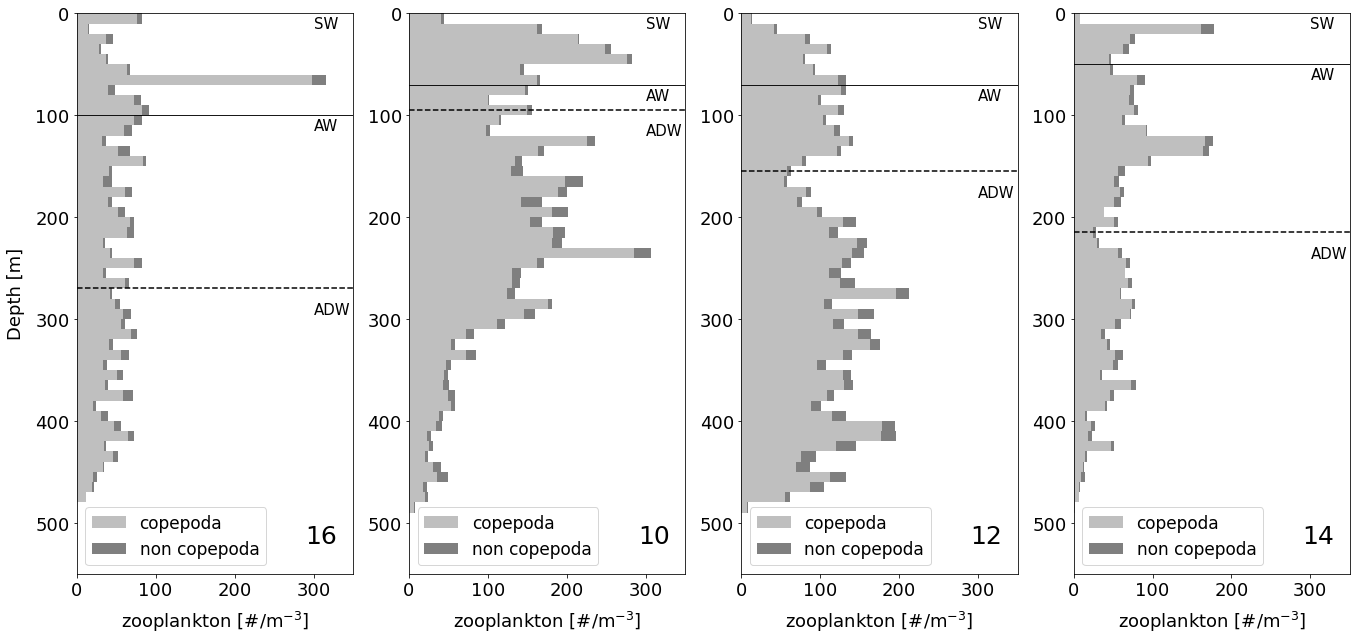

In [201]:
# Based on the cruise and profilenumber of ISC, import data from excel file
fig = plt.figure(constrained_layout=False, figsize =(19, 9))
gs = fig.add_gridspec(1, 4)

n = 0
for i in loki_stations:
    cruise, station = i.split('_')[0], int(i.split('_')[1].split('-')[0])
    depth, vol = loki_vol[i]
    bin_vol = (vol/depth)*10
    bins = np.linspace(0,500,51)
    #  from here specific station
    isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]
    loki_station_df = loki_df[loki_df['station'].str.contains(i) & loki_df['animal']==True] # select corresponding loki station
    
    copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
    copepoda_depth = copepoda_df['loki_depth'].to_list()

    no_copepoda_df = loki_station_df[loki_station_df['copepod']==False]
    no_copepoda_depth = no_copepoda_df['loki_depth'].to_list()
    
    c_hist = np.histogram(np.array(copepoda_depth),  bins)
    n_hist = np.histogram(np.array(no_copepoda_depth),  bins)

    ax = fig.add_subplot(gs[0,n])
    c_count_divide = c_hist[0]/bin_vol
    n_count_divide = n_hist[0]/bin_vol
    ax.barh(c_hist[1][0:-1], c_count_divide, color='gray', alpha=0.5, align='edge', height=10)
    ax.barh(n_hist[1][0:-1], n_count_divide, color='black', alpha=0.5, align='edge', height=10, left=c_count_divide)
    ax.legend({'copepoda': 'gray', 'non copepoda': 'black'}, loc='lower left', fontsize=17)
    ax.set_xlim(0,350)
    ax.set_ylim(0,550)
    ax.set_xlabel('zooplankton [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()


    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    ax.text(300, 15, 'SW', size=15)
    ax.text(300, up+15, 'AW', size=15)
    ax.text(300, down+25, 'ADW', size=15)

    ax.text(290, 520, station, size=25)

    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        
    #ax.annotate(fig_anot[n], xy=(-10, -20), xycoords='data', annotation_clip=False, size=22)
    ##### for real value #####
    print(station, 'copepoda', c_count_divide.sum(), 'noncopeoda', n_count_divide.sum(), 'total', c_count_divide.sum() + n_count_divide.sum(), 
          'copepoda_P',(c_count_divide.sum()/( c_count_divide.sum() + n_count_divide.sum() ) )*100, 
          'no_copepoda_P', ( n_count_divide.sum()/(c_count_divide.sum() + n_count_divide.sum() ) )*100 )
    
    
    n += 1

fig.tight_layout()

plt.savefig(os.path.join(plt_path,'zooplankton_all_hit.pdf'), dpi=300)
plt.show()
plt.close()

copepoda_dict = {16: (2533.2, 311.6) , 10: (5683.7, 430.5) , 12: (5233.5, 529.3) ,14: (2668.9, 225.9)}

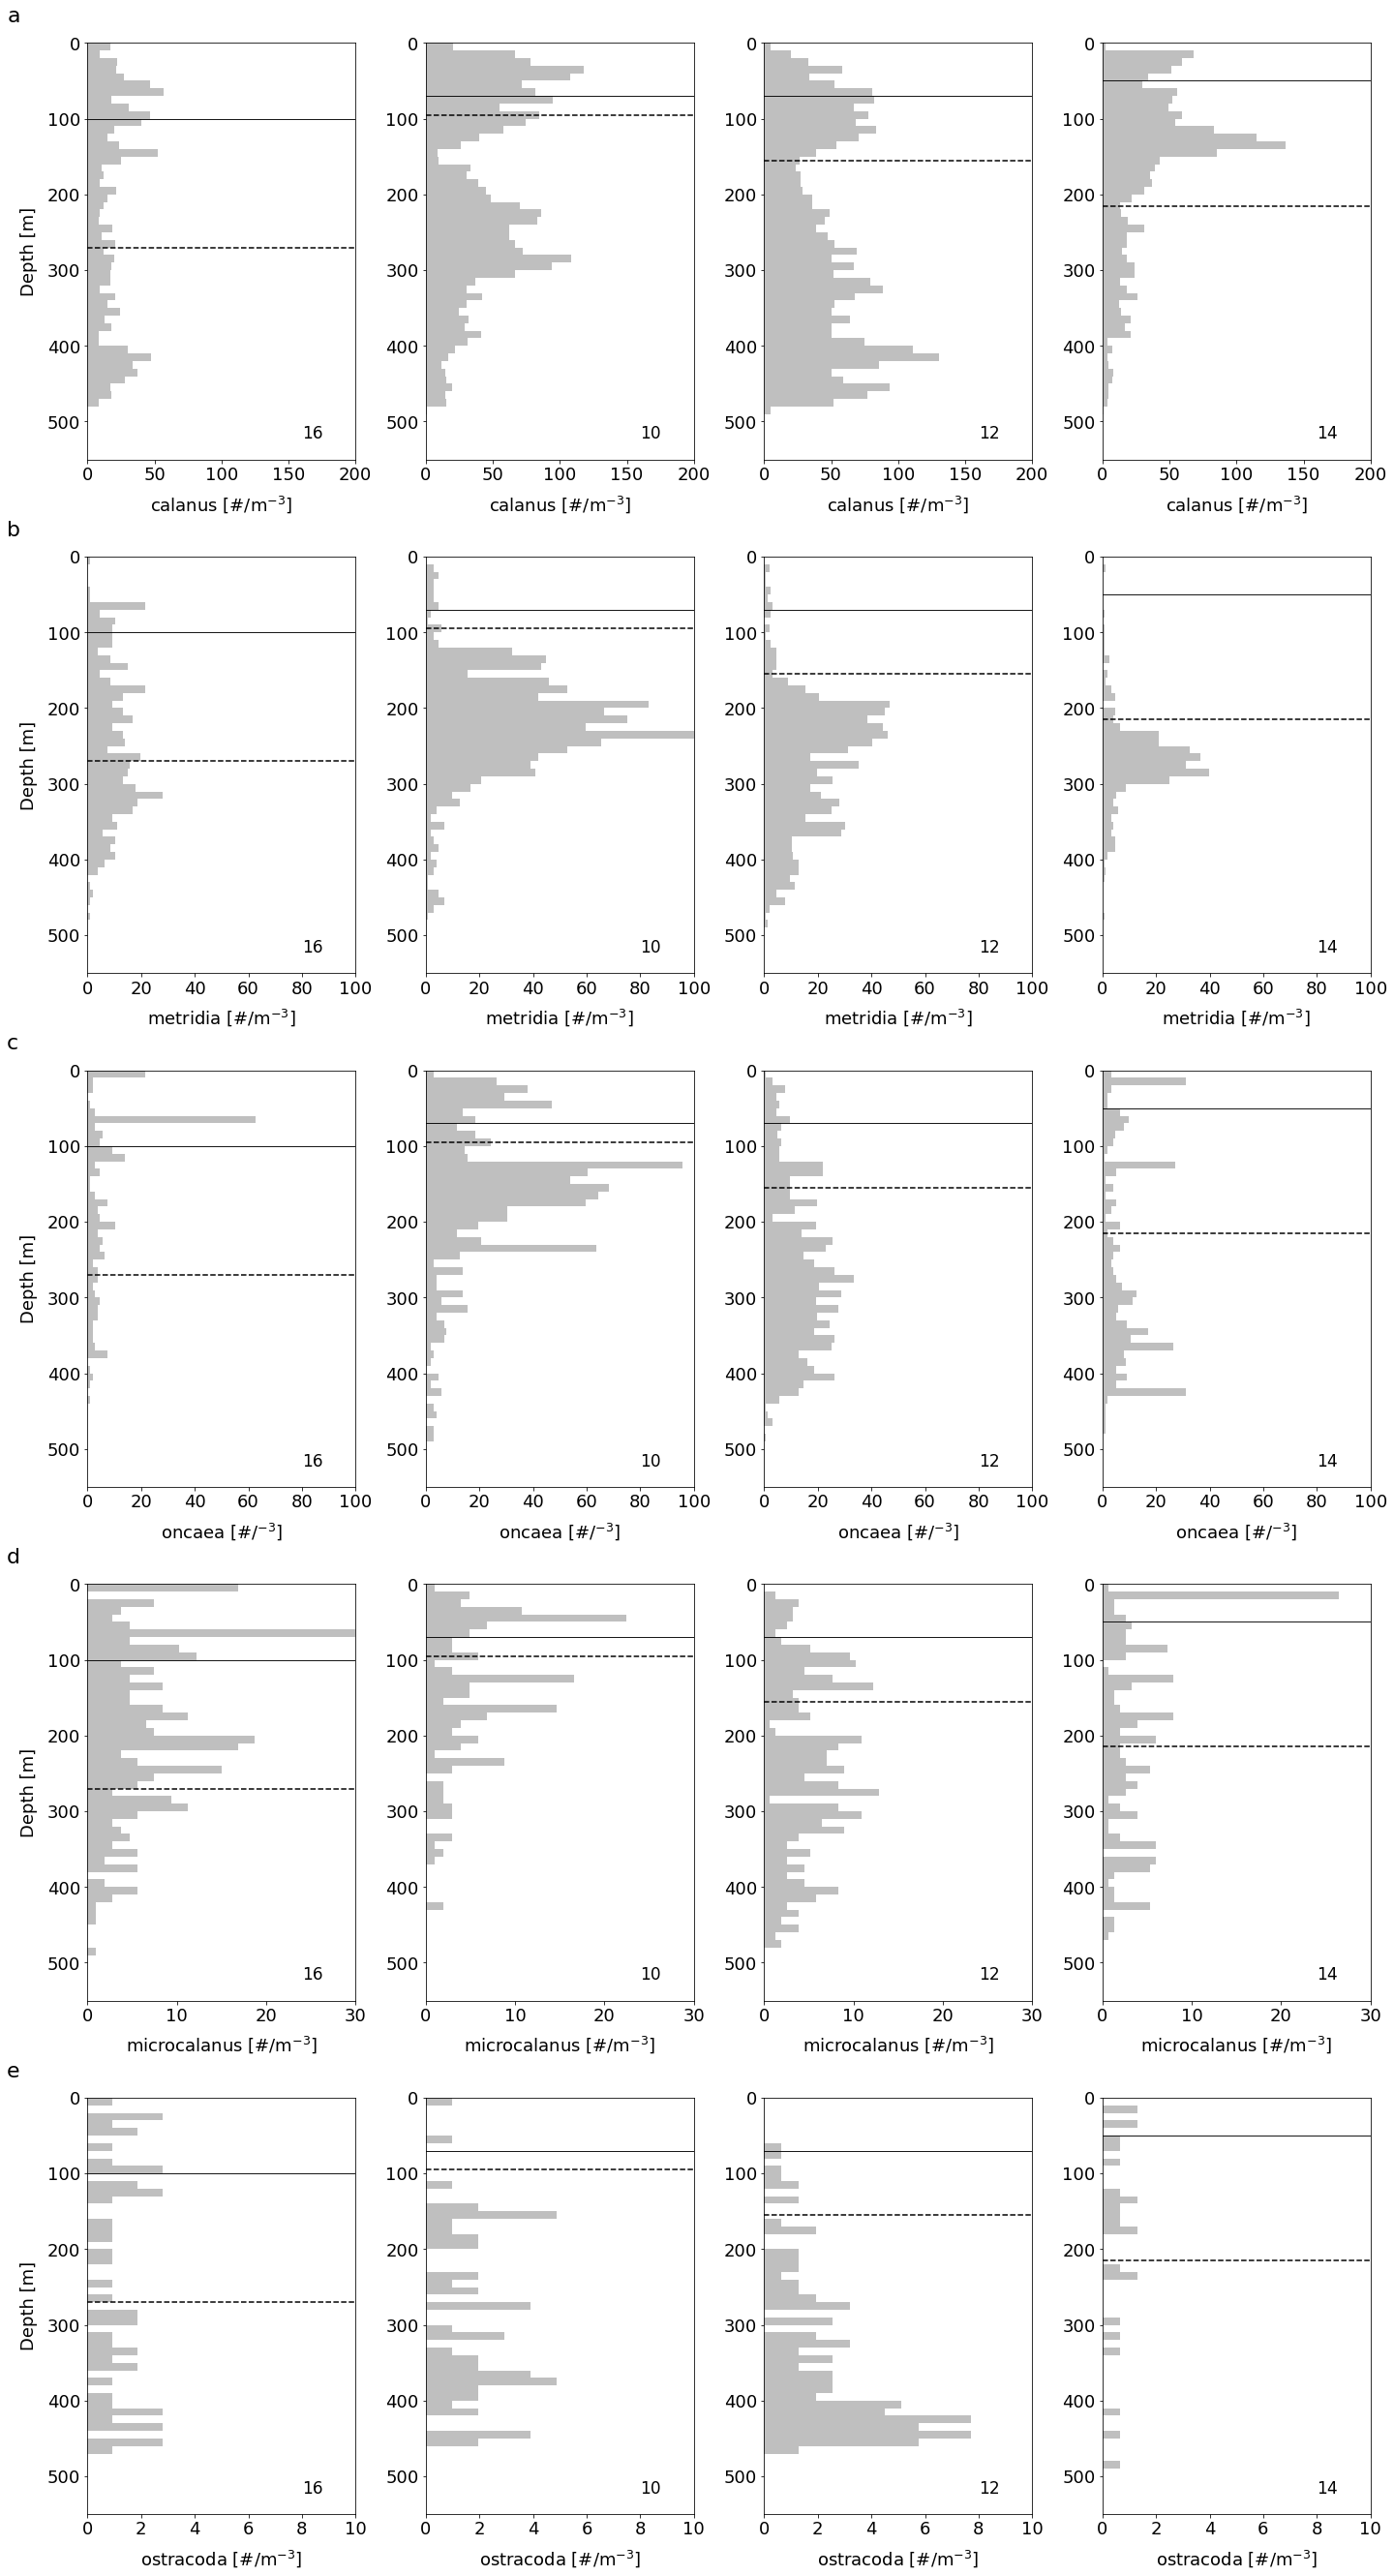

  station copeoda (#/m⁻³, % ) non copeoda (#/m⁻³, %) ) calanus (#/m⁻³, % )  \
0      16       2533.2 , 89.0             311.6 , 11.0       1040.6 , 41.1   
1      10       5683.7 , 93.0              430.5 , 7.0       2390.4 , 42.1   
2      12       5233.5 , 90.8              529.3 , 9.2       2747.0 , 52.5   
3      14       2668.9 , 92.2              225.9 , 7.8       1531.5 , 57.4   

  metridia (#/m⁻³, % ) oncaea (#/m⁻³, % ) microcalanus (#/m⁻³, % )  \
0         440.8 , 17.4        233.9 , 9.2             358.4 , 14.1   
1        1048.3 , 18.4       968.3 , 17.0              169.8 , 3.0   
2         730.7 , 14.0       671.0 , 12.8              243.1 , 4.6   
3         290.1 , 10.9       343.1 , 12.9              149.0 , 5.6   

  pseudocalanus (#/m⁻³, % )  
0                36.5 , 1.4  
1               424.6 , 7.5  
2               213.6 , 4.1  
3                33.8 , 1.3  


In [213]:
# each zooplankton distribution

n = 0
fig = plt.figure(constrained_layout=False, figsize=(20, 37))
copepoda_df = pd.DataFrame()
for i in loki_stations:
    cruise, station = i.split('_')[0], int(i.split('_')[1].split('-')[0])
    depth, vol = loki_vol[i]
    bin_vol = (vol/depth)*10
    bins = np.linspace(0,500,51)
    #  from here specific station
    loki_station_df = loki_df[loki_df['station'].str.contains(i) & loki_df['animal']==True] # select corresponding loki station
    
    metridia_depth = loki_station_df.loc[loki_station_df['genus']=='Metridia', 'loki_depth']
    calanus_depth = loki_station_df.loc[loki_station_df['genus']=='Calanus', 'loki_depth']
    microcalanus_depth = loki_station_df.loc[loki_station_df['genus']=='Microcalanus', 'loki_depth']
    pseudocalanus_depth = loki_station_df.loc[loki_station_df['genus']=='Pseudocalanus', 'loki_depth']
    oncaea_depth = loki_station_df.loc[loki_station_df['genus']=='Oncaea', 'loki_depth']
    ostracoda_depth = loki_station_df.loc[loki_station_df['class']=='Ostracoda', 'loki_depth']
    
    m_hist = np.histogram(np.array(metridia_depth),  bins)
    c_hist = np.histogram(np.array(calanus_depth),  bins)
    mi_hist = np.histogram(np.array(microcalanus_depth),  bins)
    onc_hist = np.histogram(np.array(oncaea_depth),  bins)
    ost_hist = np.histogram(np.array(ostracoda_depth),  bins)
    pseu_hist = np.histogram(np.array(pseudocalanus_depth),  bins)
    
    c_divide = c_hist[0]/bin_vol
    m_divide = m_hist[0]/bin_vol
    onc_divide = onc_hist[0]/bin_vol
    mi_divide = mi_hist[0]/bin_vol
    ost_divide = ost_hist[0]/bin_vol
    pseu_divide = pseu_hist[0]/bin_vol
    


    spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)
    
    # calanus
    ax = fig.add_subplot(spec[0, n])
    ax.barh(c_hist[1][0:-1], c_divide, color='gray', alpha=0.5, align='edge', height=10)
    ax.set_xlim(0,200)
    ax.set_ylim(0,550)
    ax.set_xlabel('calanus [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()


    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    #ax.text(300, 15, 'SW', size=15)
    #ax.text(300, up+15, 'AW', size=15)
    #ax.text(300, down+25, 'ADW', size=15)

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)

    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        ax.annotate(fig_anot[0], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
    
    # metridia
    ax = fig.add_subplot(spec[1, n])
    ax.barh(m_hist[1][0:-1], m_divide, color='gray', alpha=0.5, align='edge', height=10)
    ax.set_xlim(0,100)
    ax.set_ylim(0,550)
    ax.set_xlabel('metridia [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()


    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    #ax.text(300, 15, 'SW', size=15)
    #ax.text(300, up+15, 'AW', size=15)
    #ax.text(300, down+25, 'ADW', size=15)

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)

    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        ax.annotate(fig_anot[1], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)

    # oncaea
    ax = fig.add_subplot(spec[2, n])
    ax.barh(onc_hist[1][0:-1], onc_divide, color='gray', alpha=0.5, align='edge', height=10)
    ax.set_xlim(0,100)
    ax.set_ylim(0,550)
    ax.set_xlabel('oncaea [#/$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()


    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    #ax.text(90, 15, 'SW', size=15)
    #ax.text(90, up+15, 'AW', size=15)
    #ax.text(90, down+25, 'ADW', size=15)

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)

    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        ax.annotate(fig_anot[2], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
        
    # microcalanus
    ax = fig.add_subplot(spec[3, n])
    ax.barh(mi_hist[1][0:-1], mi_divide, color='gray', alpha=0.5, align='edge', height=10)
    ax.set_xlim(0,30)
    ax.set_ylim(0,550)
    ax.set_xlabel('microcalanus [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()


    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    #ax.text(300, 15, 'SW', size=15)
    #ax.text(300, up+15, 'AW', size=15)
    #ax.text(300, down+25, 'ADW', size=15)

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)

    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        ax.annotate(fig_anot[3], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
        
    # Ostracoda
    ax = fig.add_subplot(spec[4, n])
    ax.barh(ost_hist[1][0:-1], ost_divide, color='gray', alpha=0.5, align='edge', height=10)
    ax.set_xlim(0,10)
    ax.set_ylim(0,550)
    ax.set_xlabel('ostracoda [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()


    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    #ax.text(40, 15, 'SW', size=15)
    #ax.text(40, up+15, 'AW', size=15)
    #ax.text(40, down+25, 'ADW', size=15)

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)

    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
        ax.annotate(fig_anot[4], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
        
    ## save summary to datframe
    copepoda_df.loc[n, 'station'] = str(int(station))
    copepoda_df.loc[n, 'copeoda (#/m\u207b\u00B3, % )'] = str( float("{:.1f}".format(copepoda_dict[station][0] ))) +' , '+ str( float("{:.1f}".format((copepoda_dict[station][0]/(copepoda_dict[station][0]+copepoda_dict[station][1]))*100 )))
    copepoda_df.loc[n, 'non copeoda (#/m\u207b\u00B3, %) )'] = str(float("{:.1f}".format(copepoda_dict[station][1]) ))+' , '+ str( float("{:.1f}".format((copepoda_dict[station][1]/(copepoda_dict[station][0]+copepoda_dict[station][1]))*100 ) ))
    copepoda_df.loc[n, 'calanus (#/m\u207b\u00B3, % )'] = str(float("{:.1f}".format(c_divide.sum()) ))+ ' , '+ str( float("{:.1f}".format(c_divide.sum()/(copepoda_dict[station][0])*100))  )
    copepoda_df.loc[n, 'metridia (#/m\u207b\u00B3, % )'] = str(float("{:.1f}".format(m_divide.sum()) ))+ ' , '+ str( float("{:.1f}".format(m_divide.sum()/(copepoda_dict[station][0])*100))  )
    copepoda_df.loc[n, 'oncaea (#/m\u207b\u00B3, % )'] = str(float("{:.1f}".format(onc_divide.sum()) ))+ ' , '+ str( float("{:.1f}".format(onc_divide.sum()/(copepoda_dict[station][0])*100))  )
    copepoda_df.loc[n, 'microcalanus (#/m\u207b\u00B3, % )'] = str(float("{:.1f}".format(mi_divide.sum()) ))+ ' , '+ str( float("{:.1f}".format(mi_divide.sum()/(copepoda_dict[station][0])*100))  )
    copepoda_df.loc[n, 'pseudocalanus (#/m\u207b\u00B3, % )'] = str(float("{:.1f}".format(pseu_divide.sum()) ))+ ' , '+ str( float("{:.1f}".format(pseu_divide.sum()/(copepoda_dict[station][0])*100))  )

    n += 1
    
    
fig.subplots_adjust(wspace=0.2, hspace=0.23) # figure adjust
fig.tight_layout()

plt.savefig(os.path.join(plt_path,'zooplankton_spp_hit.pdf'), dpi=300)
plt.show()
plt.close()

copepoda_df.to_latex(os.path.join(file_path, 'plankton_percent.tex'), index=False)

print(copepoda_df)


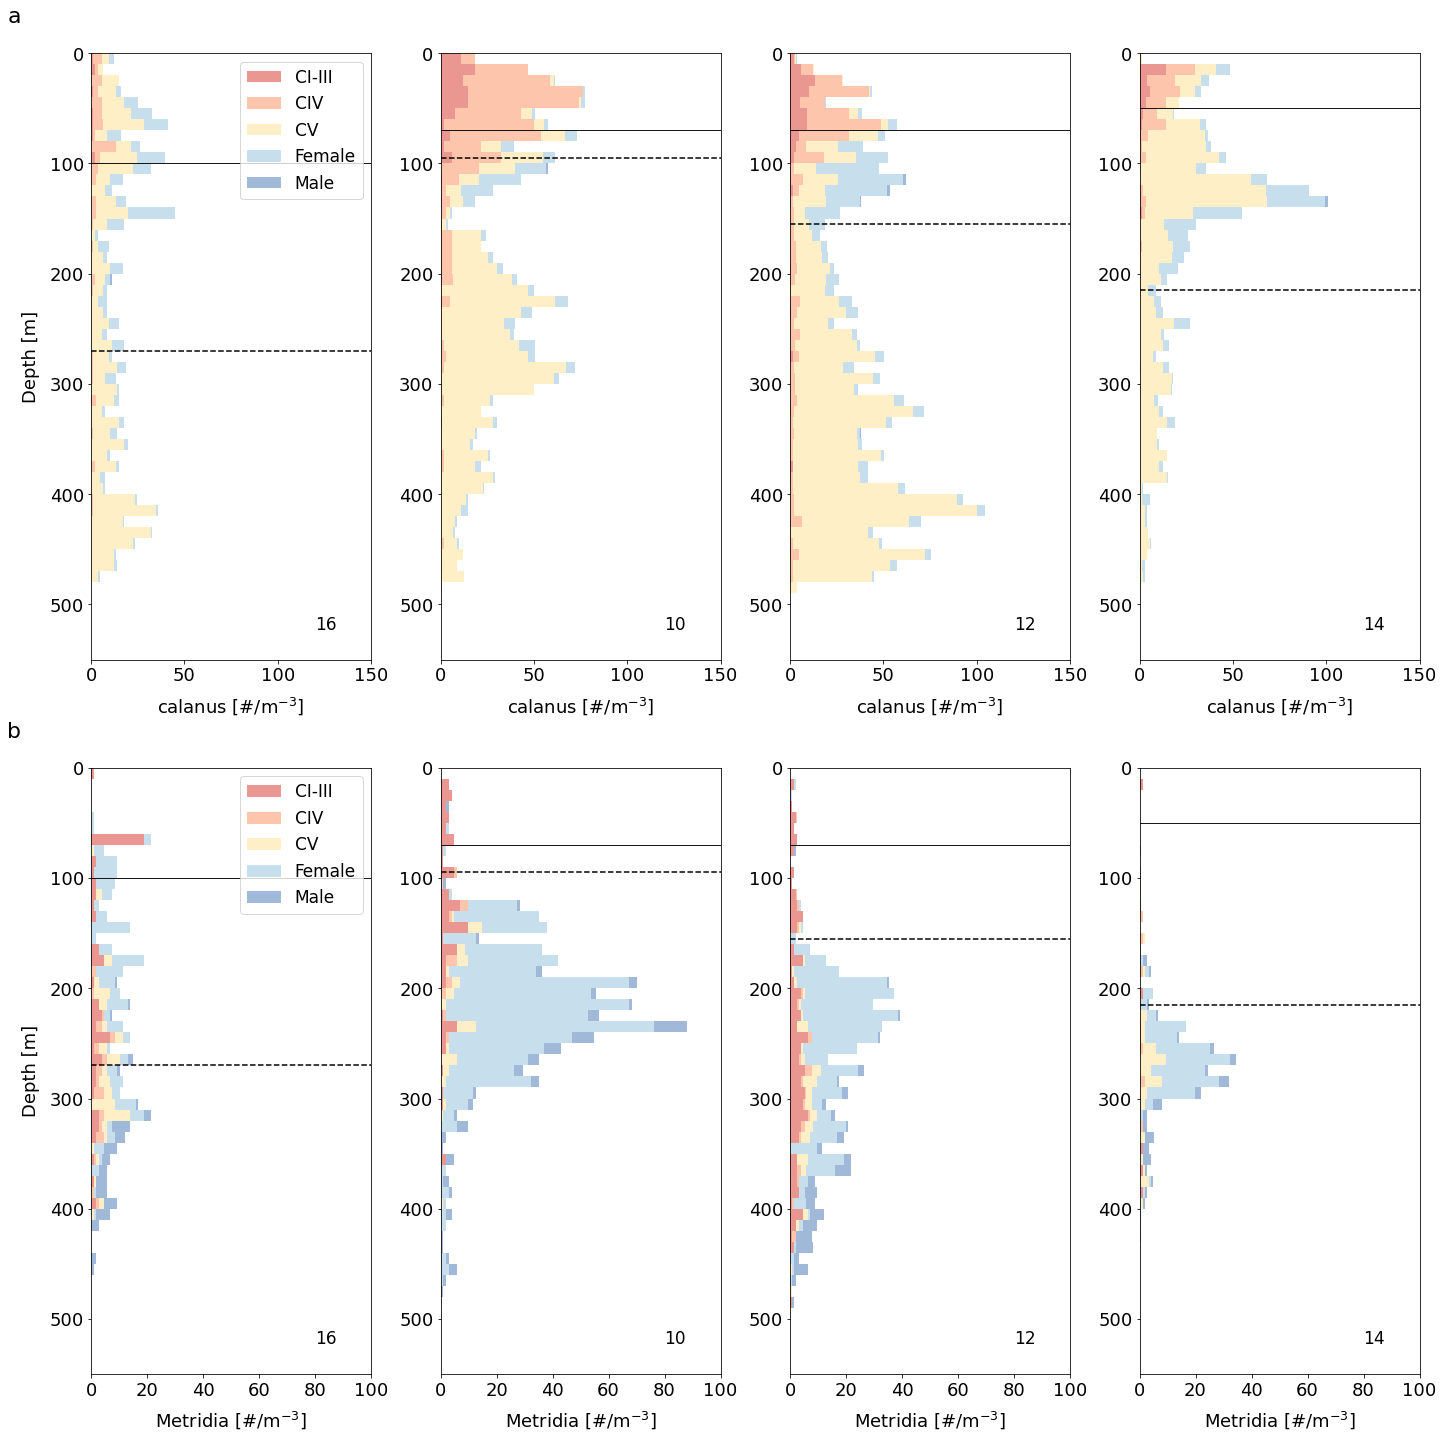

In [144]:
all_c_df = pd.DataFrame()
all_m_df = pd.DataFrame()
all_o_df = pd.DataFrame()

n = 0
fig = plt.figure(constrained_layout=False, figsize=(20, 20))
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

for i in loki_stations:
    cruise, station = i.split('_')[0], int(i.split('_')[1].split('-')[0])
    depth, vol = loki_vol[i]
    bin_vol = (vol/depth)*10
    bins = np.linspace(0,500,51)
    #  from here specific station
    loki_station_df = loki_df[loki_df['station'].str.contains(i) & loki_df['animal']==True] # select corresponding loki station
    
    m_df = loki_station_df[loki_station_df['genus']=='Metridia']
    all_m_df = all_m_df.append(m_df)
    
    m_CIII = m_df.loc[m_df['developmental_stage'] == 'CIII', 'loki_depth']
    m_CIV = m_df.loc[m_df['developmental_stage'] == 'CIV', 'loki_depth']
    m_CV = m_df.loc[m_df['developmental_stage'] == 'CV', 'loki_depth']
    m_f = m_df.loc[m_df['developmental_stage'] == 'female', 'loki_depth']
    m_m = m_df.loc[m_df['developmental_stage'] == 'male', 'loki_depth']
    
    m_CIII_hist = np.histogram(np.array(m_CIII),  bins)
    m_CIV_hist = np.histogram(np.array(m_CIV),  bins)
    m_CV_hist = np.histogram(np.array(m_CV),  bins)
    m_f_hist = np.histogram(np.array(m_f),  bins)
    m_m_hist = np.histogram(np.array(m_m),  bins)
    
    m_CIII_div = m_CIII_hist[0]/bin_vol
    m_CIV_div = m_CIV_hist[0]/bin_vol
    m_CV_div = m_CV_hist[0]/bin_vol
    m_f_div = m_f_hist[0]/bin_vol
    m_m_div = m_m_hist[0]/bin_vol

    
    c_df = loki_station_df[loki_station_df['genus']=='Calanus']
    all_c_df = all_c_df.append(c_df)
    
    c_CIII = c_df.loc[c_df['developmental_stage'] == 'CIII', 'loki_depth']
    c_CIV = c_df.loc[c_df['developmental_stage'] == 'CIV', 'loki_depth']
    c_CV = c_df.loc[c_df['developmental_stage'] == 'CV', 'loki_depth']
    c_f = c_df.loc[c_df['developmental_stage'] == 'female', 'loki_depth']
    c_m = c_df.loc[c_df['developmental_stage'] == 'male', 'loki_depth']
    
    c_CIII_hist = np.histogram(np.array(c_CIII),  bins)
    c_CIV_hist = np.histogram(np.array(c_CIV),  bins)
    c_CV_hist = np.histogram(np.array(c_CV),  bins)
    c_f_hist = np.histogram(np.array(c_f),  bins)
    c_m_hist = np.histogram(np.array(c_m),  bins)

    c_CIII_div = c_CIII_hist[0]/bin_vol
    c_CIV_div = c_CIV_hist[0]/bin_vol
    c_CV_div = c_CV_hist[0]/bin_vol
    c_f_div = c_f_hist[0]/bin_vol
    c_m_div = c_m_hist[0]/bin_vol


    
    #calanus plot   
    ax = fig.add_subplot(spec[0, n])
    ax.barh(c_CIII_hist[1][0:-1], c_CIII_div, color='#d73027', alpha=0.5, align='edge', height=10)
    ax.barh(c_CIII_hist[1][0:-1], c_CIV_div, color='#fc8d59', alpha=0.5, align='edge', height=10, left=c_CIII_div)
    ax.barh(c_CIII_hist[1][0:-1], c_CV_div, color='#fee090', alpha=0.5, align='edge', height=10, left=c_CIV_div+c_CIII_div)
    ax.barh(c_CIII_hist[1][0:-1], c_f_div, color='#91bfdb', alpha=0.5, align='edge', height=10, left=c_CIV_div+c_CIII_div+c_CV_div)
    ax.barh(c_CIII_hist[1][0:-1], c_m_div, color='#4575b4', alpha=0.5, align='edge', height=10, left=c_CIV_div+c_CIII_div+c_CV_div+c_f_div)
    
    if n==0:
        ax.legend({'CI-III': '#d73027', 'CIV': '#fc8d59', 'CV': '#fee090', 'Female':'#91bfdb', 'Male':'#4575b4'}, loc='upper right', fontsize=17)
        ax.annotate(fig_anot[0], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
             
    ax.set_xlim(0,150)
    ax.set_ylim(0,550)
    ax.set_xlabel('calanus [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()

    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)
    
    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
    
    # metridia plot
    ax = fig.add_subplot(spec[1, n])
    
    ax.barh(m_CIII_hist[1][0:-1], m_CIII_div, color='#d73027', alpha=0.5, align='edge', height=10)
    ax.barh(m_CIII_hist[1][0:-1], m_CIV_div, color='#fc8d59', alpha=0.5, align='edge', height=10, left=m_CIII_div)
    ax.barh(m_CIII_hist[1][0:-1], m_CV_div, color='#fee090', alpha=0.5, align='edge', height=10, left=m_CIV_div+m_CIII_div)
    ax.barh(m_CIII_hist[1][0:-1], m_f_div, color='#91bfdb', alpha=0.5, align='edge', height=10, left=m_CV_div+m_CIV_div+m_CIII_div)
    ax.barh(m_CIII_hist[1][0:-1], m_m_div, color='#4575b4', alpha=0.5, align='edge', height=10, left=m_f_div+m_CV_div+m_CIV_div+m_CIII_div)
    
    if n==0:
        ax.legend({'CI-III': '#d73027', 'CIV': '#fc8d59', 'CV': '#fee090', 'Female':'#91bfdb', 'Male':'#4575b4'}, loc='upper right', fontsize=17)
        ax.annotate(fig_anot[1], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
             
    ax.set_xlim(0,100)
    ax.set_ylim(0,550)
    ax.set_xlabel('Metridia [#/m$^{-3}$]', color = 'black', fontsize=18, labelpad =10)
    ax.tick_params(axis='both', labelsize=18)
    ax.invert_yaxis()

    # add more
    up, down = wm_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)
   
    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
    
    n += 1
fig.tight_layout()
plt.savefig(os.path.join(plt_path,'stage_hit.pdf'), dpi=300)
plt.show()
plt.close()


In [50]:
# particle data vertical profile

# Based on the cruise and profilenumber of ISC, import data from excel file
fig = plt.figure(constrained_layout=False, figsize =(19, 9))
gs = fig.add_gridspec(1, 4)

n = 0
for i in isc_stations:
    cruise, station = i.split('_')[0], i.split('_')[1]
    #  from here specific station
    isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]
    loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
    
    copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
    copepoda_depth = copepoda_df['loki_depth'].to_list()
    
    ax = fig.add_subplot(gs[0,n])
    ax.barh( isc_station_df['depth'], isc_station_df['abd_150-500']+isc_station_df['abd_500-1000'], color='black', alpha=0.2, align='center', height=10)
    ax.set_xlabel('total particle abundance [#/L]', color = 'black', fontsize=18)
    ax.set_ylim(0,500)
    ax.set_xlim(0,60)
    ax.tick_params(axis='both', labelsize=18)
    
    
    sec_axs = ax.twiny()
    sec_axs.plot(isc_station_df['vol_150-500']+isc_station_df['vol_500-1000'], isc_station_df['depth'], color='red', linewidth= 1)
    sec_axs.set_xlabel('total particle volume [ppm]', color = 'red', fontsize=18, labelpad=10)
    sec_axs.set_xlim(0, 10)
    sec_axs.invert_yaxis()
    sec_axs.tick_params(axis='x', labelsize=18)

    # add more
    up, down = wm_isc_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    ax.text(50, 15, 'SW', size=15)
    ax.text(50, up+15, 'AW', size=15)
    ax.text(50, down+25, 'ADW', size=15)
    ax.text(50, 480, station, size=25)
    
    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
    
    n += 1
fig.tight_layout()
plt.savefig(os.path.join(plt_path,'particle_total.pdf'), dpi=300)
#plt.show()
plt.close()

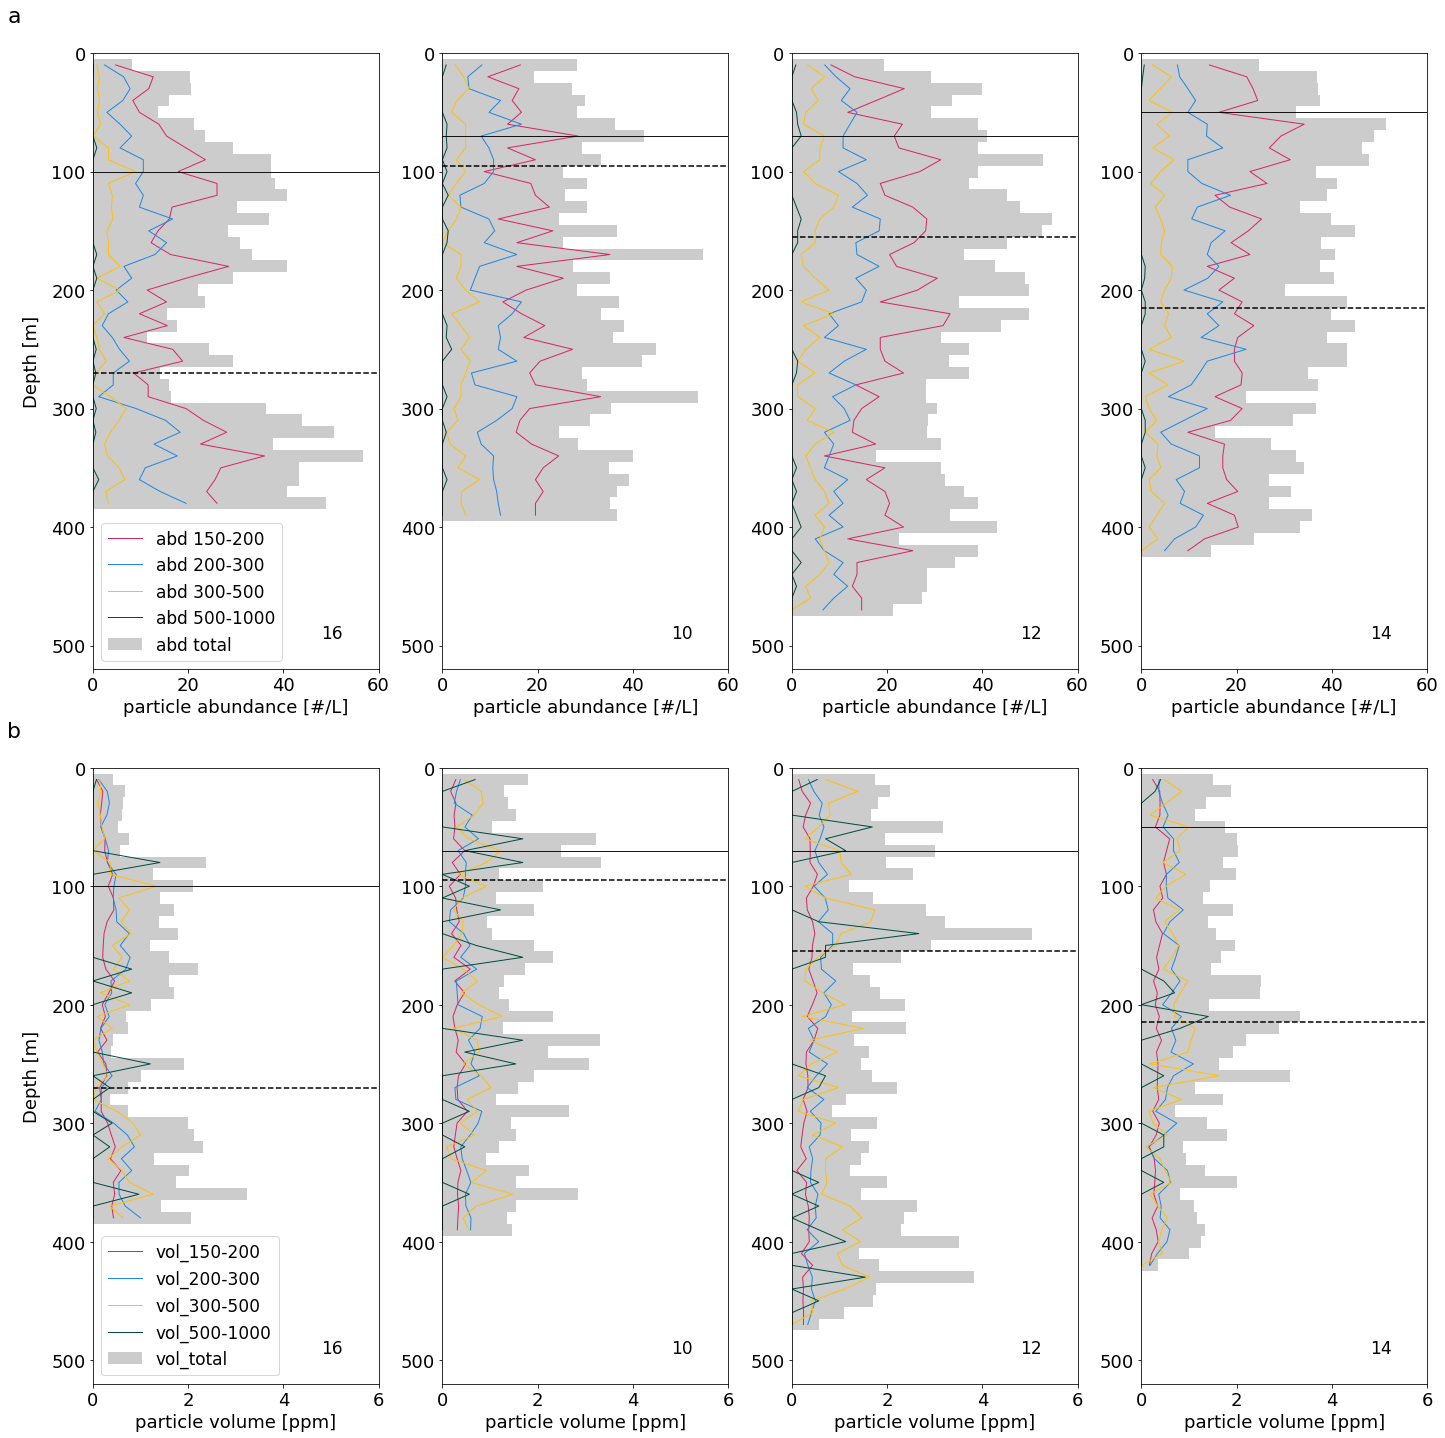

In [240]:
# particle data vertical profile

# Based on the cruise and profilenumber of ISC, import data from excel file
fig = plt.figure(constrained_layout=False, figsize =(20, 20))
gs = fig.add_gridspec(2, 4)

n = 0
isc_sum_df = pd.DataFrame()
for i in isc_stations:
    cruise, station = i.split('_')[0], int(i.split('_')[1])
    #  from here specific station
    isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]

    # abundance
    ax = fig.add_subplot(gs[0,n])
    ax.barh( isc_station_df['depth'], isc_station_df['abd_total']-isc_station_df['abd_1000-100000'], color='black', alpha=0.2, align='center', height=10, label='abd total')
    ax.plot(isc_station_df['abd_150-200'], isc_station_df['depth'], color='#DA2567', linewidth= 1, label='abd 150-200')
    ax.plot(isc_station_df['abd_200-300'], isc_station_df['depth'], color='#1E88E5', linewidth= 1, label='abd 200-300')
    ax.plot(isc_station_df['abd_300-400'] + isc_station_df['abd_400-500'], isc_station_df['depth'], color='#FFC107', linewidth= 1, label='abd 300-500')
    ax.plot(isc_station_df['abd_500-1000'], isc_station_df['depth'], color='#004D40', linewidth= 1, label='abd 500-1000' )
    
    
    ax.set_xlabel('particle abundance [#/L]', color = 'black', fontsize=18)
    ax.set_ylim(0,520)
    ax.set_xlim(0,60)
    ax.tick_params(axis='both', labelsize=18)
    
    up, down = wm_isc_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    ax.invert_yaxis()
    
    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
    if n==0:
        ax.legend(loc='lower left', fontsize=17)
        ax.annotate(fig_anot[0], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
    
    ax.annotate(station, xy=(0, 470),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)
    
    ## volume
    ax = fig.add_subplot(gs[1,n])
    ax.barh( isc_station_df['depth'], isc_station_df['vol_total']-isc_station_df['vol_1000-100000'], color='black', alpha=0.2, align='center', height=10, label='vol_total')
    ax.plot(isc_station_df['vol_150-200'], isc_station_df['depth'], color='#DA2567', linewidth= 1, label='vol_150-200')
    ax.plot(isc_station_df['vol_200-300'], isc_station_df['depth'], color='#1E88E5', linewidth= 1, label='vol_200-300')
    ax.plot(isc_station_df['vol_300-400']+isc_station_df['vol_400-500'], isc_station_df['depth'], color='#FFC107', linewidth= 1, label='vol_300-500')
    ax.plot(isc_station_df['vol_500-1000'], isc_station_df['depth'], color='#004D40', linewidth= 1, label='vol_500-1000')
    
    
    ax.set_xlabel('particle volume [ppm]', color = 'black', fontsize=18)
    ax.set_ylim(0,520)
    ax.set_xlim(0,6)
    ax.tick_params(axis='both', labelsize=18)
    
    ax.invert_yaxis()
    

    # add more
    
    up, down = wm_isc_dict[i]
    ax.axhline(y=up, color='black', ls='-', linewidth=0.9)
    ax.axhline(y=down, color='black', ls='--')
    #ax.text(50, 15, 'SW', size=15)
    #ax.text(50, up+15, 'AW', size=15)
    #ax.text(50, down+25, 'ADW', size=15)
    #ax.text(50, 480, station, size=25)
    ax.annotate(station, xy=(0, 470),  xycoords='data',
            xytext=(0.8, 0.05), textcoords='axes fraction', size=17)
    
    if n==0:
        ax.set_ylabel('Depth [m]', color = 'black', fontsize=18, labelpad =10)
    if n==0:
        ax.legend(loc='lower left', fontsize=17)
        #ax.legend({'vol 150-500': 'red', 'vol 500-1000': 'blue', 'vol total': 'black'}, loc='lower right', fontsize=17)
        ax.annotate(fig_anot[1], xy=(-0.3, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)
    
    
    #summary data
    isc_sum_df.loc[n, 'station'] = station
    
    isc_sum_df.loc[n, 'abd 150-200'] = str( float("{:.1f}".format(isc_station_df['abd_150-200'].mean()) )) + ' , ' + str( float("{:.1f}".format((isc_station_df['abd_150-200'].sum() / (isc_station_df['abd_total']-isc_station_df['abd_1000-100000']).sum())*100)) )
    isc_sum_df.loc[n, 'abd 200-300'] = str( float("{:.1f}".format(isc_station_df['abd_200-300'].mean()) )) + ' , ' + str( float("{:.1f}".format((isc_station_df['abd_200-300'].sum() / (isc_station_df['abd_total']-isc_station_df['abd_1000-100000']).sum())*100)) )
    isc_sum_df.loc[n, 'abd 300-500'] = str( float("{:.1f}".format( (isc_station_df['abd_300-400']+isc_station_df['abd_300-400']).mean()) )) + ' , ' + str( float("{:.1f}".format(((isc_station_df['abd_300-400']+isc_station_df['abd_300-400']).sum() / (isc_station_df['abd_total']-isc_station_df['abd_1000-100000']).sum())*100)) )
    isc_sum_df.loc[n, 'abd 500-1000'] = str( float("{:.1f}".format(isc_station_df['abd_500-1000'].mean()) )) + ' , ' + str( float("{:.1f}".format((isc_station_df['abd_500-1000'].sum() / (isc_station_df['abd_total']-isc_station_df['abd_1000-100000']).sum())*100)) )
    
    isc_sum_df.loc[n, 'vol 150-200'] = str( float("{:.1f}".format(isc_station_df['vol_150-200'].mean()) )) + ' , ' + str( float("{:.1f}".format((isc_station_df['vol_150-200'].sum() / (isc_station_df['vol_total']-isc_station_df['vol_1000-100000']).sum())*100)) )
    isc_sum_df.loc[n, 'vol 200-300'] = str( float("{:.1f}".format(isc_station_df['vol_200-300'].mean()) )) + ' , ' + str( float("{:.1f}".format((isc_station_df['vol_150-200'].sum() / (isc_station_df['vol_total']-isc_station_df['vol_1000-100000']).sum())*100)) )
    isc_sum_df.loc[n, 'vol 300-500'] = str( float("{:.1f}".format( (isc_station_df['vol_300-400'] + isc_station_df['vol_400-500'] ).mean()) )) + ' , ' + str( float("{:.1f}".format(((isc_station_df['vol_300-400'] + isc_station_df['vol_400-500'] ).sum() / (isc_station_df['vol_total']-isc_station_df['vol_1000-100000']).sum())*100)) )
    isc_sum_df.loc[n, 'vol 500-1000'] = str( float("{:.1f}".format(isc_station_df['vol_500-1000'].mean()) )) + ' , ' + str( float("{:.1f}".format((isc_station_df['vol_150-200'].sum() / (isc_station_df['vol_total']-isc_station_df['vol_1000-100000']).sum())*100)) )
    
    
        
    n += 1

fig.tight_layout()
plt.savefig(os.path.join(plt_path,'particle_size_each_five.pdf'), dpi=300)
plt.show()
plt.close()

In [239]:
isc_sum_df.to_latex(os.path.join(file_path,'particle_table.tex'), index=False)

# Linear Discriminant analysis

In [52]:
# LOKI zooplankton
# normalise data

wm_c = {'surf':'#BF0622' , 'atl': '#1E88E5', 'atl_d':'#EFC601'}

isc_sel_df = isc_all_df[['abd_150-500','abd_500-1000','abd_total', 'vol_150-500','vol_500-1000','vol_total','avg_ESD', 'tag']]
all_df_scaled = StandardScaler().fit_transform(isc_sel_df[['abd_total', 'vol_total', 'avg_ESD']])

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, isc_sel_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
fig, ax = plt.subplots(2,2, figsize =(15, 15))

ax1 = ax[0,0]
ax1.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
ax1.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

ax1.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c= wm_c['surf'], label='Surface')
ax1.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c= wm_c['atl'], label='Atlantic')
ax1.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c= wm_c['atl_d'], label='Atlantic_Dense')

ax1.tick_params(axis='both', labelsize=15)
#ax1.legend(loc='lower left', fontsize=15)
ax1.set_xlabel('LD1', size = 18)
ax1.set_ylabel('LD2', size = 18)
ax1.set_title('abd total + vol total + avg ESD', size = 15)
ax1.annotate(fig_anot[0], xy=(-0.1, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)


##########
all_df_scaled = StandardScaler().fit_transform(isc_sel_df[['abd_150-500', 'vol_150-500']])

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, isc_sel_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
ax2 = ax[0,1]

ax2.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
ax2.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

ax2.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c=wm_c['surf'], label='Surface')
ax2.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c= wm_c['atl'], label='Atlantic')
ax2.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c= wm_c['atl_d'], label='Atlantic_Dense')

ax2.tick_params(axis='both', labelsize=15)
#ax2.legend(loc='lower left', fontsize=15)
ax2.set_xlabel('LD1', size = 18)
ax2.set_ylabel('LD2', size = 18)
ax2.set_title('abd 150-500 + vol 150-500', size = 15)
ax2.annotate(fig_anot[1], xy=(-0.1, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)


########
all_df_scaled = StandardScaler().fit_transform(isc_sel_df[['abd_500-1000', 'vol_500-1000']])

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, isc_sel_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
ax3 = ax[1,0]

ax3.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
ax3.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

ax3.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c= wm_c['surf'], label='Surface')
ax3.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c= wm_c['atl'], label='Atlantic')
ax3.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c= wm_c['atl_d'], label='Atlantic_Dense')

ax3.tick_params(axis='both', labelsize=15)
#ax3.legend(loc='lower left', fontsize=15)
ax3.set_xlabel('LD1', size = 18)
ax3.set_ylabel('LD2', size = 18)
ax3.set_title('abd 500-1000 + vol 500-1000', size = 15)
ax3.annotate(fig_anot[2], xy=(-0.1, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)



#######
all_df_scaled = StandardScaler().fit_transform(isc_sel_df[['abd_total', 'vol_total']])

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, isc_sel_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
ax4 = ax[1,1]


ax4.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
ax4.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

ax4.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c= wm_c['surf'], label='Surface')
ax4.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c= wm_c['atl'], label='Atlantic')
ax4.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c= wm_c['atl_d'], label='Atlantic_Dense')

ax4.tick_params(axis='both', labelsize=15)
ax4.legend(loc='lower left', fontsize=15)
ax4.set_xlabel('LD1', size = 18)
ax4.set_ylabel('LD2', size = 18)
ax4.set_title('abd total + vol total', size = 15)
ax4.annotate(fig_anot[3], xy=(-0.1, 1.05), xycoords='axes fraction', annotation_clip=False, size=22)

fig.tight_layout()
plt.savefig(os.path.join(plt_path,'all_LDA_particle.pdf'), dpi=300)


#plt.show()
plt.close()

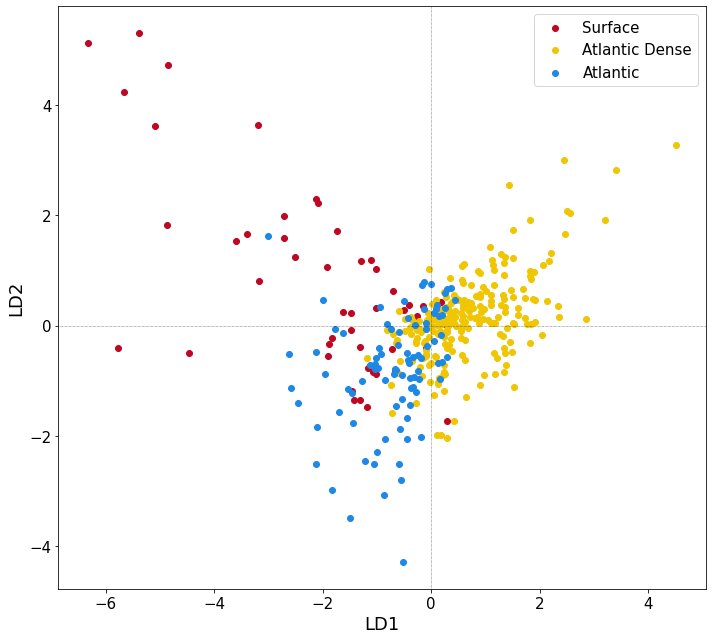

In [146]:
# LOKI zooplankton LDA by water mass
# normalise data
all_df_scaled = StandardScaler().fit_transform(all_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']])


lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, all_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
fig = plt.figure(figsize =(10, 9))


plt.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
plt.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c=wm_c['surf'], label='Surface')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c=wm_c['atl_d'], label='Atlantic Dense')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c=wm_c['atl'], label='Atlantic')

plt.tick_params(axis='both', labelsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('LD1', size = 18)
plt.ylabel('LD2', size = 18)

fig.tight_layout()
plt.savefig(os.path.join(plt_path,'LDA_zooplankton_watermass.pdf'), dpi=300)
plt.show()
plt.close()

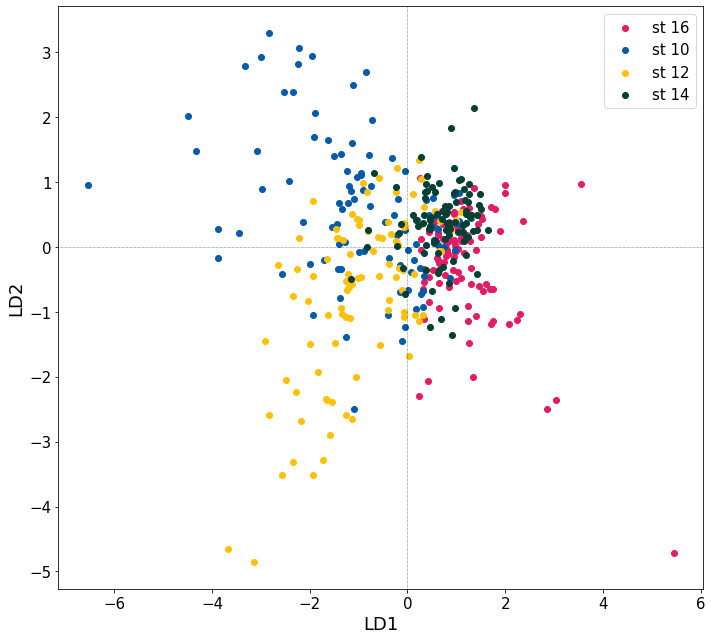

In [147]:
# LOKI zooplankton LDA by 
# normalise data
all_df_scaled = StandardScaler().fit_transform(all_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']])


lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, all_df['station'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['station']


# plot
fig = plt.figure(figsize =(10, 9))


plt.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
plt.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='PS107_016-4'], df_lda_component['y'].loc[df_lda_component['target']=='PS107_016-4'], c='#E21C65', label='st 16')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='PS107_010-5'], df_lda_component['y'].loc[df_lda_component['target']=='PS107_010-5'], c='#045CA9', label='st 10')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='PS107_012-4'], df_lda_component['y'].loc[df_lda_component['target']=='PS107_012-4'], c='#FFC107', label= 'st 12')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='PS107_014-5'], df_lda_component['y'].loc[df_lda_component['target']=='PS107_014-5'], c='#024035', label='st 14')

plt.tick_params(axis='both', labelsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('LD1', size = 18)
plt.ylabel('LD2', size = 18)

fig.tight_layout()

plt.savefig(os.path.join(plt_path,'LDA_zooplankton_station.pdf'), dpi=300)
plt.show()
plt.close()

# CCA (Canonical Correspondense Analysis) 

In [56]:
all_df['st_wm'] = all_df['station']+'_'+all_df['tag']

loki_count_df = pd.DataFrame(columns=['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 
                                      'Microcalanus', 'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto', 'st_wm'])


for st_wm in list(all_df['st_wm'].drop_duplicates()):
    st_wm_df = all_df.loc[all_df['st_wm']==st_wm]
    sumry = st_wm_df.drop( ['depth', 'tag', 'station','st_wm'], axis=1).sum()
    df = pd.DataFrame(sumry.values, index = sumry.index)
    df = df.T
    df['st_wm'] = st_wm
    loki_count_df =loki_count_df.append(df)
    
# water mass to numeber masking
sf_mask = loki_count_df['st_wm'].str.contains('surface')
aw_mask = loki_count_df['st_wm'].str.contains('atlantic') & ~loki_count_df['st_wm'].str.contains('atlantic_dense')
adw_mask = loki_count_df['st_wm'].str.contains('atlantic_dense')

loki_count_df['surface'] = sf_mask
loki_count_df['atlantic'] = aw_mask
loki_count_df['atlantic_dense'] = adw_mask

loki_count_df = loki_count_df.mask(loki_count_df == True, 1)
loki_count_df = loki_count_df.mask(loki_count_df == False, 0)

loki_count_df.reset_index(drop=True, inplace=True)

CCA1     0.415593
CCA2     0.097176
CCA3     0.276265
CCA4     0.123247
CCA5     0.041465
CCA6     0.025409
CCA7     0.007606
CCA8     0.007135
CCA9     0.004262
CCA10    0.001161
CCA11    0.000681
dtype: float64


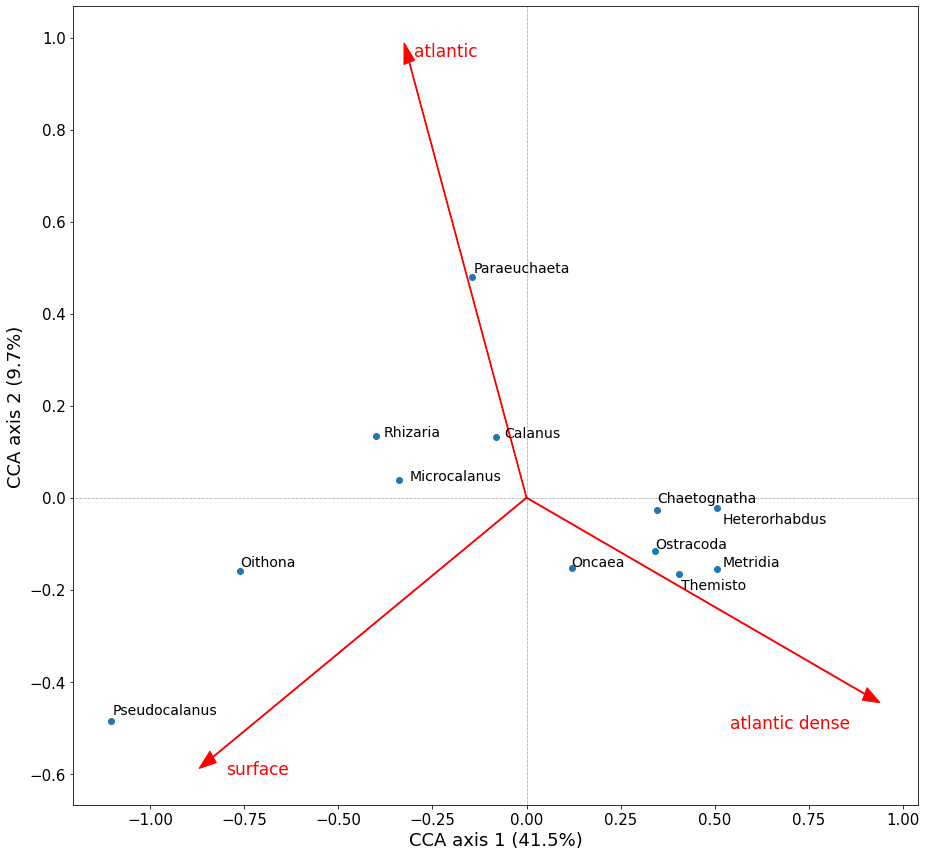

In [149]:
env_var = loki_count_df[['surface', 'atlantic', 'atlantic_dense']]
spp = loki_count_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus', 
                     'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']]

loki_cca = cca(spp, env_var, scaling=2)
spp_cca = loki_cca.features
wm_cca = loki_cca.biplot_scores


print(loki_cca.proportion_explained)

fig = plt.figure(figsize =(13, 12))

plt.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
plt.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

# draw water mass arrow
for i in range(0, len(wm_cca['CCA1'])):
    plt.arrow(0, 0, wm_cca['CCA1'][i], wm_cca['CCA2'][i], width= 0.002, head_width=0.03, color='red')

# add point of spp.
plt.scatter(spp_cca['CCA1'], spp_cca['CCA2'])


# add text
plt.text(0.347943, -0.01 , 'Chaetognatha' , size=14)
plt.text(-0.38, 0.134, 'Rhizaria' , size=14)
plt.text(0.342, -0.11, 'Ostracoda' , size=14)
plt.text(-0.06, 0.130817, 'Calanus' , size=14)
plt.text(0.52, -0.055, 'Heterorhabdus' , size=14)
plt.text(0.52, -0.15, 'Metridia' , size=14)
plt.text(-0.31, 0.037, 'Microcalanus' , size=14)
plt.text(-0.76, -0.15, 'Oithona' , size=14)
plt.text(0.12, -0.15, 'Oncaea' , size=14)
plt.text(-0.14, 0.49, 'Paraeuchaeta' , size=14)
plt.text(-1.1, -0.47, 'Pseudocalanus' , size=14)
plt.text(0.41, -0.2, 'Themisto' , size=14)

plt.text(-0.8, -0.6, 'surface' , size=17, color='red')
plt.text(-0.3, 0.96, 'atlantic' , size=17, color='red')
plt.text(0.54, -0.5, 'atlantic dense' , size=17, color='red')

plt.xlabel('CCA axis 1 (41.5%)', size=18)
plt.ylabel('CCA axis 2 (9.7%)', size=18)

plt.tick_params(axis='both', labelsize=15)

fig.tight_layout()

plt.savefig(os.path.join(plt_path,'CCA.pdf'), dpi=300)
plt.show()
plt.close()

# Heat map and correlation

In [183]:
# depth dict
#fig = plt.figure(constrained_layout=True, figsize =(19, 9))
#gs = fig.add_gridspec(1, 4)

zoo_ud = {'PS107_10_3': (120, 330), 'PS107_12_2': (160, 480), 'PS107_14_7': (220, 320), 'PS107_16_2': (100, 270)}

all_m_count = []
all_onc_count = []
all_c_count = []
all_micro_count = []
all_pseudo_count = []

all_abd_total = []
all_abd_mip = []
all_abd_map = []
all_vol_total = [] 
all_vol_mip = []
all_vol_map = []


n = 0
for i in isc_stations:
    if i == 'PS107_16_2':
        continue
    else:
        cruise, station = i.split('_')[0], i.split('_')[1]
        # from here specific station
        isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]
        loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
        
        depth, vol = loki_vol[loki_station_df['station'].to_list()[0]]
        bin_vol = (vol/depth)*10

        copepoda_df = loki_station_df.loc[loki_station_df['copepod']==True] # df only for copepoda
        copepoda_depth = copepoda_df['loki_depth'].to_list()

        metridia_df = loki_station_df.loc[loki_station_df['genus']=='Metridia'] # df only for metridia
        metridia_depth = metridia_df['loki_depth'].to_list()

        calanus_df = loki_station_df.loc[loki_station_df['genus']=='Calanus'] # df only for calanus
        calanus_depth = calanus_df['loki_depth'].to_list()

        oncaea_df = loki_station_df.loc[loki_station_df['genus']=='Oncaea'] # df only for Oncaea
        oncaea_depth = oncaea_df['loki_depth'].to_list()
        
        microcalanus_df = loki_station_df.loc[loki_station_df['genus']=='Microcalanus'] # df only for calanus
        microcalanus_depth = microcalanus_df['loki_depth'].to_list()

        pseudo_df = loki_station_df.loc[loki_station_df['genus']=='Pseudocalanus'] # df only for Oncaea
        pseudo_depth = pseudo_df['loki_depth'].to_list() 

        # up and down
        up, down = zoo_ud[i]
        up_index = int(up/10)
        down_index = int(down/10)

        ost_hist = np.histogram(np.array(ostracoda_depth),  bins)
        c_divide = c_hist[0]/bin_vol
        ax.barh(c_hist[1][0:-1], c_divide, color='gray', alpha=0.5, align='edge', height=10)
        
      
        # get interval data
        bins = np.linspace(0,500,51)
        
        m_hist = np.histogram(np.array(metridia_depth), bins)
        c_hist = np.histogram(np.array(calanus_depth), bins)
        onc_hist = np.histogram(np.array(oncaea_depth), bins)
        micro_hist = np.histogram(np.array(microcalanus_depth), bins)
        pseudo_hist = np.histogram(np.array(pseudo_depth), bins)
        

        m_div = (m_hist[0]/bin_vol)/m_hist[0].sum()
        c_div = (c_hist[0]/bin_vol)/c_hist[0].sum()
        onc_div = (onc_hist[0]/bin_vol)/onc_hist[0].sum()
        micro_div = (micro_hist[0]/bin_vol)/micro_hist[0].sum()
        pseudo_div = (pseudo_hist[0]/bin_vol)/pseudo_hist[0].sum()
        

        abd_total = isc_station_df['abd_total'].to_list()/isc_station_df['abd_total'].sum()
        abd_mip = isc_station_df['abd_150-500'].to_list() /isc_station_df['abd_150-500'].sum()
        abd_map = isc_station_df['abd_500-1000'].to_list() /isc_station_df['abd_500-1000'].sum()

        vol_total = isc_station_df['vol_total'].to_list() /isc_station_df['vol_total'].sum()
        vol_mip = isc_station_df['vol_150-500'].to_list() /isc_station_df['vol_150-500'].sum()
        vol_map = isc_station_df['vol_500-1000'].to_list()/isc_station_df['vol_500-1000'].sum()


        all_m_count.extend(m_div[up_index:down_index+1])
        all_c_count.extend(c_div[up_index:down_index+1])
        all_onc_count.extend(onc_div[up_index:down_index+1])
        all_micro_count.extend(micro_div[up_index:down_index+1])
        all_pseudo_count.extend(pseudo_div[up_index:down_index+1])
        
        
        all_abd_total.extend(abd_total[up_index:down_index+1])
        all_abd_mip.extend(abd_mip[up_index:down_index+1])
        all_abd_map.extend(abd_map[up_index:down_index+1])
        all_vol_total.extend(vol_total[up_index:down_index+1])
        all_vol_mip.extend(vol_mip[up_index:down_index+1])
        all_vol_map.extend(vol_map[up_index:down_index+1])


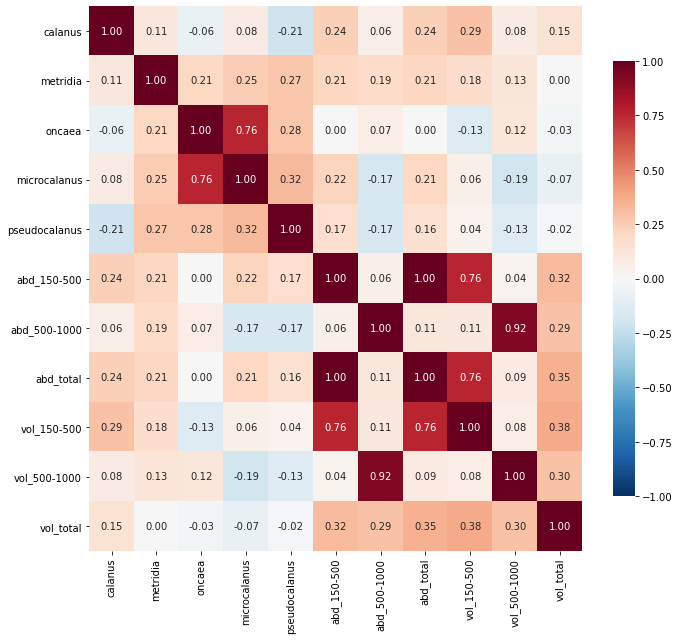

In [184]:
cor_df = pd.DataFrame(list(zip(all_c_count, all_m_count, all_onc_count, all_micro_count, all_pseudo_count, all_abd_mip, all_abd_map, all_abd_total, all_vol_mip, all_vol_map, all_vol_total)), 
                      columns = ['calanus', 'metridia', 'oncaea', 'microcalanus', 'pseudocalanus', 'abd_150-500', 'abd_500-1000', 'abd_total', 'vol_150-500', 'vol_500-1000', 'vol_total'])

all_cop = cor_df['calanus'] + cor_df['metridia'] + cor_df['oncaea'] + cor_df['microcalanus'] + cor_df['pseudocalanus']


fig = plt.figure(constrained_layout=False, figsize =(10, 9))
gs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(gs[0,0])
corr = cor_df[['calanus', 'metridia', 'oncaea', 'microcalanus', 'pseudocalanus', 'abd_150-500', 'abd_500-1000', 'abd_total', 'vol_150-500', 'vol_500-1000', 'vol_total']].corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='RdBu_r', vmin=-1, vmax=1, fmt='.2f', cbar_kws={'shrink': .8}, annot=True)

fig.tight_layout()

plt.savefig(os.path.join(plt_path,'heat_cor_all_perc.pdf'), dpi=300)
plt.show()
plt.close()

<ipython-input-194-c6de93830ad2>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  matrix = scatter_matrix(cor_df[['calanus', 'metridia', 'oncaea', 'microcalanus', 'pseudocalanus',


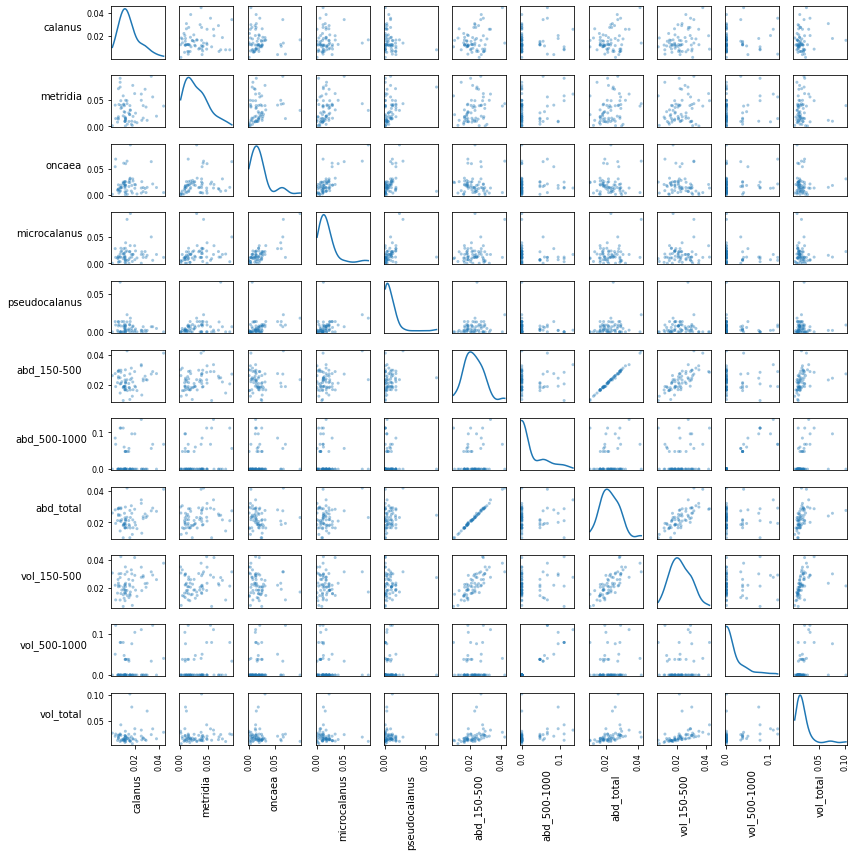

In [194]:
fig = plt.figure(constrained_layout=False, figsize =(12, 12))
gs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(gs[0,0])
matrix = scatter_matrix(cor_df[['calanus', 'metridia', 'oncaea', 'microcalanus', 'pseudocalanus', 
                       'abd_150-500', 'abd_500-1000', 'abd_total', 'vol_150-500', 'vol_500-1000', 'vol_total']], 
               alpha = 0.4,  diagonal = 'kde', ax=ax)

for m in matrix.flatten():
    m.xaxis.label.set_rotation(90)
    m.yaxis.label.set_rotation(0)
    m.yaxis.label.set_ha('right')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.tight_layout()

plt.savefig(os.path.join(plt_path,'matrix_cor_all_perc.pdf'), dpi=300)
plt.show()
plt.close()


In [ ]:
# zooplankton abundance

n = 0
fig = plt.figure(constrained_layout=False, figsize=(15, 20))
spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)


for i in isc_stations:
    cruise, station = i.split('_')[0], i.split('_')[1]
    depth, vol = loki_vol[i]
    bin_vol = (vol/depth)*10
    bins = np.linspace(0,500,51)
    #  from here specific station
    isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]
    loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
    
    loki_family_dict = dict(loki_station_df['genus'].value_counts())
    
    ax = fig.add_subplot(spec[n, 0])
    ax.bar(loki_family_dict.keys(), loki_family_dict.values(), color='black') # family abundance check
    ax.tick_params(rotation=290, axis='x')
      
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    ax.set_ylabel('count', size = 18)
    ax.set_ylim(0, 4500)

    # add more

    ax.annotate(station, xy=(0, 520),  xycoords='data',
            xytext=(0.9, 0.8), textcoords='axes fraction', size=23)
    

    n += 1
    
fig.subplots_adjust(hspace=0.8) # figure adjust

plt.savefig(os.path.join(plt_path,'zoo_histo_station.pdf'), dpi=300)
#plt.show()
plt.close()



In [ ]:
c_CIII = all_c_df[all_c_df['developmental_stage'] == 'CIII']
c_CIV = all_c_df[all_c_df['developmental_stage'] == 'CIV']
c_CV = all_c_df[all_c_df['developmental_stage'] == 'CV']
c_f = all_c_df[all_c_df['developmental_stage'] == 'female']
c_m = all_c_df[all_c_df['developmental_stage'] == 'male']


fig = plt.figure(constrained_layout=False, figsize=(40, 10))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig)


bins = np.linspace(0,50,100)
color = 'black'

ax1 = fig.add_subplot(spec[0, 0])
ax1.hist(c_CIII['area_sqrmm'], bins, color=color, label='CIII', rwidth=1000)

ax2 = fig.add_subplot(spec[0, 1])
ax2.hist(c_CIV['area_sqrmm'], bins, color=color, label='CIV')

ax3 = fig.add_subplot(spec[0, 2])
ax3.hist(c_CV['area_sqrmm'], bins, color=color, label='CV')

ax4 = fig.add_subplot(spec[0, 3])
ax4.hist(c_f['area_sqrmm'], bins, color=color, label='Female')

ax5 = fig.add_subplot(spec[0, 4])
ax5.hist(c_m['area_sqrmm'], bins, color=color, label='Male')

for axes in fig.axes:
    axes.legend(loc='upper right',fontsize=15 )
    axes.tick_params(axis='both', labelsize=18)
    #axes.set_ylim(0, 1200)
    #axes.set_xlim(-1, 20)
    axes.set_xlabel('sqrmm', size = 18)
    axes.set_ylabel('count', size = 18)




plt.savefig(os.path.join(plt_path,'zooplankton_size.pdf'), dpi=300)
plt.show()
plt.close()